# Lab 4 Key: Modeling Approaches
Now that we have cleaned our data and done an initial data exploration we can start modeling! In this lab we will create several simple linear regressions to explore basic approaches to modeling and discuss the results.By the end of this lab you will be able to:
- Prepare data for modeling
- Fit a model and use it for prediction.
- Compare the performance of different models.
- Describe the differences between some primary types of machine learning algorithms and when to apply them.

We will explore models of `OCI` based upon segment age, segment type, and AADT. To that end the data we will be using contains records for each observation of a segment with segments observed over the course of multiple years.

## Additional Data Cleaning
While we've already done some data cleaning we can continue tidying up our data and do some additional exploratory analysis to ensure that our data is acurate for use in our model. To do this we will utilize simple visualization and perform some additional data cleaning as needed

In [3]:
### Only run this code if using Jupyter Lite ###
#Installs plotting library
%pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Import our data analysis library
import pandas as pd
#Import a plotting library
import matplotlib.pyplot as plt
#Import a plotting library useful for styling a plot
import seaborn as sns

In [5]:
#Read our data and visualize the structure
df = pd.read_csv('../data/lab_4.csv')
df.head()

,id,SURFACE_TY,REGION,YR_SURF,AADT_2011,year,OCI
0,0006P-Both-1,Asphalt,3,2011,7210,2004,96.36244
1,0006P-Both-1,Asphalt,3,2011,7210,2005,89.93015
2,0006P-Both-1,Asphalt,3,2011,7210,2006,90.22396
3,0006P-Both-1,Asphalt,3,2011,7210,2007,86.52546
4,0006P-Both-1,Asphalt,3,2011,7210,2008,82.41007


First things first, we need to devise a column for the age of the segment when it was observed, we can do this simply by calculating a new column. Then let's visualize the relationship between age and OCI using a boxplot.

In [6]:
#get the age relative to the last resurfacing as a new column
df['age'] = df['year'] - df['YR_SURF']

<Axes: xlabel='age', ylabel='OCI'>

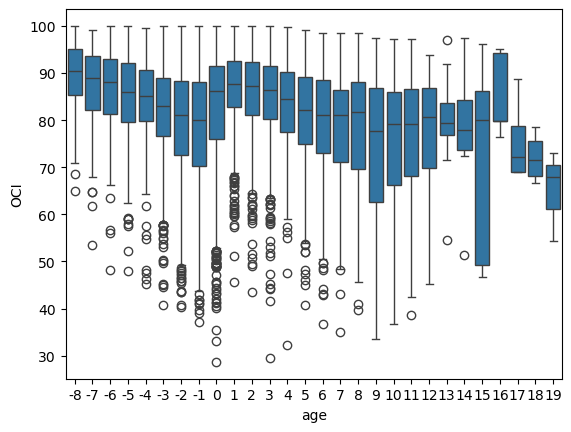

In [7]:
#Visualize the relationship between age and OCI as a boxplot
sns.boxplot(df, x='age', y='OCI')

What's up with the negative ages? It seems as though segments recieve maintenance about once every eight to ten years and it's likely that there were some inacuracies with how these observations were recorded. Let's modify the age for these records by adjusting them forward to better match the pattern we expect.

<Axes: xlabel='age', ylabel='OCI'>

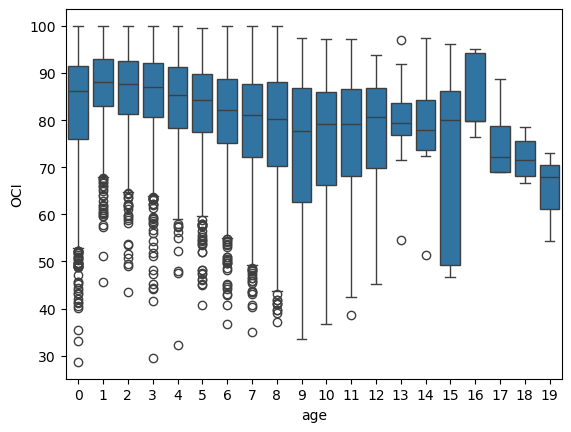

In [8]:
#Find rows where there is a negative age
negative_age_mask = df['age'] < 0
#Find the minimum age of the data frame
min_age = df['age'].min()

#For the rows where age is negative, add the absolute value of the minimum age plus one to the age. This shifts the negative records forward by 9 years. 
df.loc[negative_age_mask, 'age'] += abs(min_age) + 1

#Visualize again to see how our change affects the data.
sns.boxplot(df, x='age', y='OCI')

We have a lot of outliers where pavements are considered poor condition. Let's filter these by keeping only rows where `OCI` is greater than 70 minus the age.

In [9]:
# Filter df to keep only rows where OCI is greater than 70 minus the age
df = df[df['OCI'] > 70 - df['age']]

<Axes: xlabel='age', ylabel='OCI'>

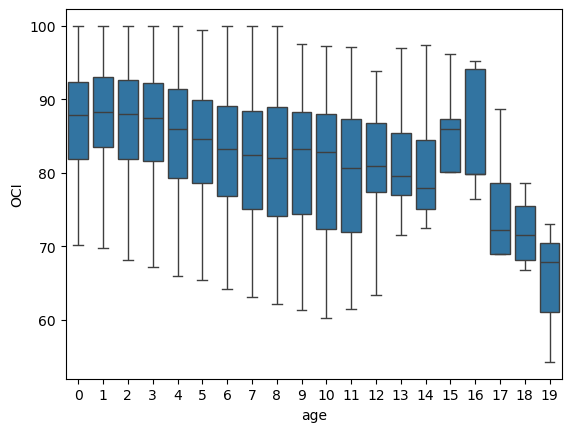

In [10]:
#Visualize again to see how our change affects the data.
sns.boxplot(df, x='age', y='OCI')

Now this looks like there is a trend we can model! There seems to be something happening to records with an age of zero however. Let's take a closer look with a histogram to see how many records there are.

<Axes: >

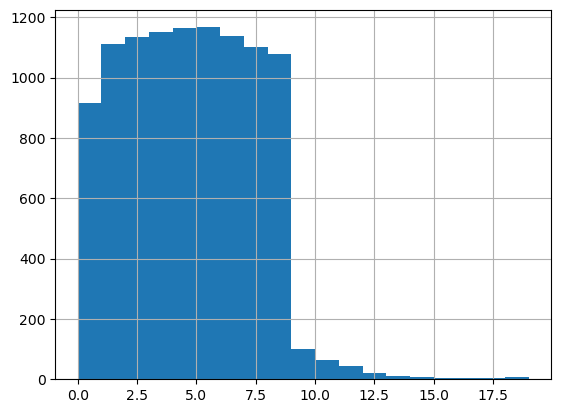

In [11]:
#Create a quick histogram of ages
df['age'].hist(bins=19)

<div class="alert alert-block alert-info"><b>Exercise:</b> Remove segments where the age is 0.</div>

In [12]:
df = df[df['age'] > 0]### Your Code Here ###

Now that we have our `age` sorted, let's create a new column that records a unique sequence id to differentiate records of a segment before and after it was surfaced. We do this by adding an additional value to the id field based on a logic test that returns true if the year observed is less than or equal to the year surfaced, otherwise it returns false.

In [13]:
#Create a series of boolean values based on the logic test.
sequence = df['year'] <= df['YR_SURF']

#Concatenate boolean values (cast to strings of '1' or '0') from sequence with the id field
df['seq_id'] = df['id'].astype(str) + '-' + (sequence).astype(int).astype(str)

#Look at how this affects our data frame
df.head()

,id,SURFACE_TY,REGION,YR_SURF,AADT_2011,year,OCI,age,seq_id
0,0006P-Both-1,Asphalt,3,2011,7210,2004,96.36244,2,0006P-Both-1-1
1,0006P-Both-1,Asphalt,3,2011,7210,2005,89.93015,3,0006P-Both-1-1
2,0006P-Both-1,Asphalt,3,2011,7210,2006,90.22396,4,0006P-Both-1-1
3,0006P-Both-1,Asphalt,3,2011,7210,2007,86.52546,5,0006P-Both-1-1
4,0006P-Both-1,Asphalt,3,2011,7210,2008,82.41007,6,0006P-Both-1-1


Now let's keep only rows where there are at least two records 

In [14]:
#Filter based upon the length of the groups of sequence id
df = df.groupby('seq_id').filter(lambda x: len(x) >= 2)

One more cleaning step! There are likely sequences that recieved maintenance but the maintenance may not have been recorded. These records could pose a challenge as we train a model, so let's remove them. To do this we will:
- Get the year-over-year change in OCI
- Infer that maintenance occured on sequences where the change was greater than 7 points to a score greater than 92 and get the values of the `seq_id`s as a list.
- Filter out the these sequences

In [15]:
#get year-over-year change in OCI
df['change'] = df.groupby('id')['OCI'].diff()

In [16]:
# Infer maintenance where condition jumps more than 7 points to > 92 OCI
maintenance_seqs = df.loc[(df['change'] > 7) & (df['OCI'] > 92), 'seq_id'].unique()

In [17]:
# Filter df to keep only records where seq_id is not in maintenance_seqs
df = df[~df['seq_id'].isin(maintenance_seqs)]

<Axes: xlabel='age', ylabel='OCI'>

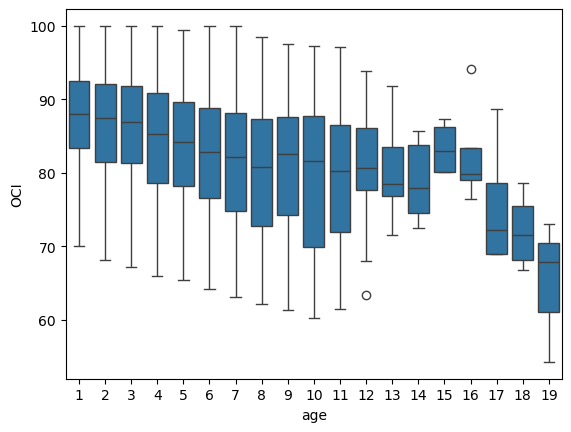

In [18]:
#Visualize again to see how our change affects the data.
sns.boxplot(df, x='age', y='OCI')

This has helped us get our data much more consistent! Before values for OCI at higher ages (around 14-15) seemed to jump but now they appear much more in line with the consistent trend.

Before we get to modeling let's plot a scatter plot with a line of best fit to see what these trends might look like. Using the seaborn `.lmplot()` method we can even adjust the order of a polynomial line of best fit (where 1 is linear, 2 is quadratic, and so on). We can also differentiate between the surface types to see if there is a meaningful difference between them.

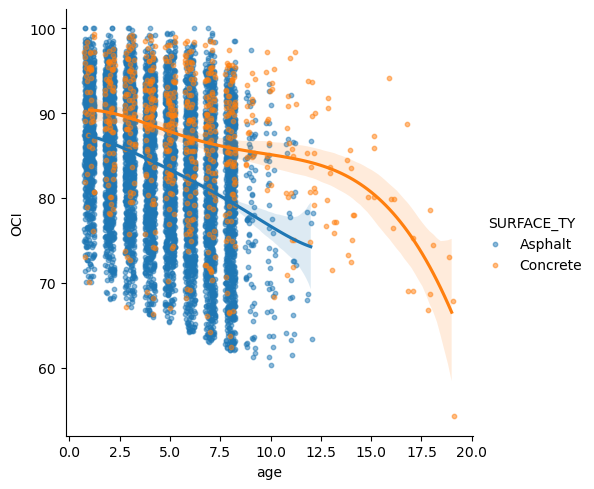

In [19]:
sns.lmplot(x='age', y='OCI', hue='SURFACE_TY', data=df,     #Define data and variables
           order=5,                                         #Change the polynomial order of the line of best fit
           scatter_kws={"alpha": 0.5, "s": 10},             #Change the visual characteristics of the scatter plot
           x_jitter=.25                                     #Add some variation to the age values displayed to make a nicer plot
          )

- What do we learn from this chart? 
- What might this mean as we begin modeling?

## Modeling
There are many types of models and many python libraries that can be used for modeling. Two prominent libraries are Scikit Learn and Statsmodels. Today we will focus on Scikit Learn but both are useful. Between the two libraries Scikit Learn offers a wider variety of modeling algorithms including decision trees and neural networks, but Statsmodels offers simplified statistical analysis similar to outputs available in other statistical modeling software such as R or Stata. As such, Statsmodels is better suited for explanatory or inferential analysis while Scikit Learn is better suited for classification or prediction.

For starters, let's import the LinearRegression module from sci-kit learn. We've also utilized a function that will simplify our ability to print some core metrics for our regressions.

In [20]:
# Import the regression function as well as functions for obtaining metrics about our models.
from sklearn.linear_model import LinearRegression
import numpy as np
import sklearn.metrics as metrics

# Create a function for us to get the metrics on our regression models quickly
# Source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-scikit-learn-like-r-does
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    # Print regression metrics
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

Let's start with a very simple linear regression just using `age` as a factor and see what we can do with the regression object.

In [21]:
# Define our x variables (must be in the form of a list)
xvars = ['age']
# Define our y variable (must be in the form of a string)
yvar = 'OCI'

# Create variables for the x and y data
x = df[xvars]
y = df[yvar]

# create a new object with a fit LinearRegression based on our x and y variable
reg = LinearRegression().fit(x,y)

Now we have a linear regression object called `reg`. There are a few things we can do with it. For starters let's get the coefficient for our x variable and the intercept:

In [22]:
# Get the coefficients for the x variables. 
reg.coef_

array([-1.00028058])

In [23]:
# Get intercept of regression function
reg.intercept_

88.60904854288457

We can also use the model to predict data. More on this later but for now let's predict based on the data we have in `x`.

In [24]:
# Use the model to predict values for each value of x
# We'll save this to calculate some metrics later on
y_pred = reg.predict(x)
y_pred

array([86.60848739, 85.60820681, 84.60792624, ..., 86.60848739,
       85.60820681, 84.60792624])

We can also get some metrics about our model including our coefficient of variation (R-squared) and other measures.

In [25]:
#Return the coefficient of variation (R-squared)
reg.score(x, y)

0.08952213429092004

In [26]:
# Use the function defined earlier to get more metrics 
# based on the y values and our predicted y values
regression_results(y, y_pred)

explained_variance:  0.0895
mean_squared_log_error:  0.0089
r2:  0.0895
MAE:  6.4699
MSE:  60.8004
RMSE:  7.7975


We can also visualize how effective our model is by graphing the predicted values in relation to the observed values.

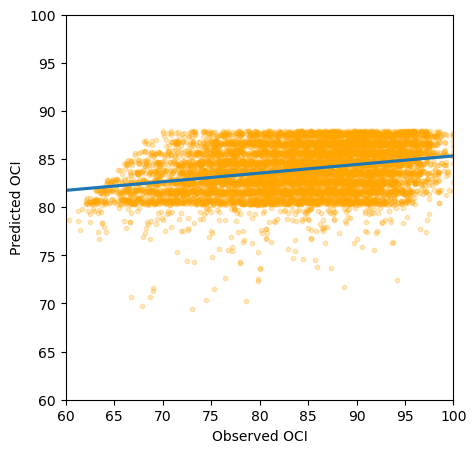

In [27]:
#Create a figure and axis object
fig, ax = plt.subplots(figsize=(5, 5)) 

#Create the regplot
sns.regplot(x=y, y=y_pred, 
            y_jitter=.35, 
            scatter_kws={"alpha": 0.25, "s": 10, 'color':'orange'}, 
            ax=ax
    )

# Label both axes more intuitively
plt.xlabel('Observed OCI')
plt.ylabel('Predicted OCI')

# Set the scales on both axes to be equivalent to better visualize model performance
ax.set_xlim([60, 100])
ax.set_ylim([60, 100])

# 
plt.show()

Now that we have done a simple linear model let's talk talk about expanding this to include other model and variable types and preprocessing.

In contrast to data cleaning (where we are ensuring our data is correct, complete, and concise), preprocessing data for modeling is where take our cleaned data and optimize it to the needs of our modeling approach. This may look like:
- Encoding categorical variables to binary columns (one hot encoding)
- Scaling data (to ensure variables with different units are on the same scale)
- Creating interaction or polynomial variables
- Spliting training and testing data (to better validate models)

Different modeling aproaches require some or all of these techniques. Typically prediction-oriented approaches (such as neural networks and random forests) can be best calibrated when spliting training and testing data to ensure models are not overfit.

Let's explore some of these techniques as well as a different type of regressor, the Random Forest regressor.
We will:
- Create an encoded field for surface type uing the pandas `.get_dummies()` function
- Define a term with the interaction between age and surface type
- Split our data into training and testing data sets
- Fit a random forest regression model
- Evaluate our model using our testing data

In [28]:
# Get a dummy column of surface type (this will return column of zeros and ones based on the surface type
df_encoded = pd.get_dummies(df, columns=['SURFACE_TY'], drop_first=True, dtype='int')

#Create interaction term by multiplying age by surface type 
df_encoded['interaction'] = df_encoded['age']*df_encoded['SURFACE_TY_Concrete']

In [29]:
# Import splitting and regression function.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [30]:
# Define our x and y variables
xvars = ['age', 'interaction']
yvar = 'OCI'

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded[xvars],      # Define x variables
    df_encoded[yvar],       # Define y variables
    test_size = 0.25,       # Define the proporiton of the data used for testing
    random_state = 1        # Set a random state so our results are repeatable
)

Now that our data is preprocessed let's fit a model.

In [31]:
# Create random forest object and fit using our training data.
rf = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)

Note, random forest models have a wide variety of hyperparameters (modifiable model characteristics), such as the `max_depth` characteristic shown here that can greatly influence how well they perform. Delving too deep into these is beyond the scope of this workshop but see what happens when you change the `max_depth` or look on the sci-kit learn documentation to see what other hyperparameters you can adjust.

Now that we have a model that has been fit, let's evaluate it by creating a prediction on our testing data and evaluating the performance.

In [32]:
# Create a set of predictions using our testing data
y_pred = rf.predict(X_test)

In [33]:
# Look at our model metrics
regression_results(y_test, y_pred)

explained_variance:  0.101
mean_squared_log_error:  0.0093
r2:  0.1007
MAE:  6.5115
MSE:  62.4326
RMSE:  7.9014


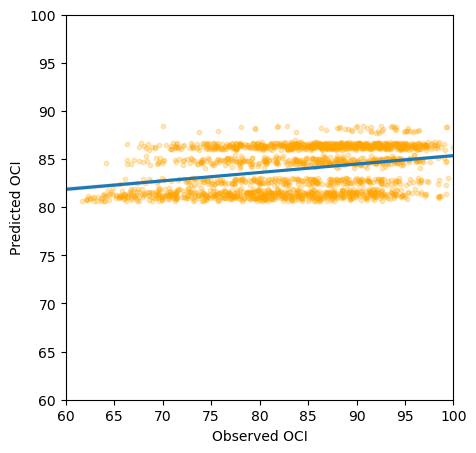

In [34]:
### Plot the observed and predicted values of our testing data ###

#Create a figure and axis object
fig, ax = plt.subplots(figsize=(5, 5)) 

#Create the regplot
sns.regplot(x=y_test, y=y_pred, 
            y_jitter=.35, 
            scatter_kws={"alpha": 0.25, "s": 10, 'color':'orange'}, 
            ax=ax
    )

# Label both axes more intuitively
plt.xlabel('Observed OCI')
plt.ylabel('Predicted OCI')

# Set the scales on both axes to be equivalent to better visualize model performance
ax.set_xlim([60, 100])
ax.set_ylim([60, 100])

# 
plt.show()

How does this model compare to the simple linear regression? Does it perform better or worse? 

## Your Turn!
Now that you have seen an example of both a linear regression and a random forest regression it's time for you to give it a try.

<div class="alert alert-block alert-info"><b>Exercise:</b> Create two more models and see how well they perform in relation to these other models by looking at the metrics of their performance. 
<ul>Create a
<li>Linear Model with <code>age</code> and <code>interaction</code> as variables.</li>
<li>Either a linear or random forest model that includes both <code>age</code> and <code>interaction</code> with the addition of <code>AADT_2011</code>.</li>
</ul>
Remember random forest models require you to split training and testing data. After creating and assessing both models briefly describe which of the models you think performs best and why.</div>

In [35]:
# Define our x and y variables
xvars = ['age', 'interaction']
yvar = 'OCI'

# Create variables for the x and y data
x = df_encoded[xvars]
y = df_encoded[yvar]

# create a new object with a fit LinearRegression based on our x and y variable
reg = LinearRegression().fit(x,y)

y_pred = reg.predict(x)

regression_results(y, y_pred)
### Your Code Here ###

explained_variance:  0.1153
mean_squared_log_error:  0.0087
r2:  0.1153
MAE:  6.3684
MSE:  59.0776
RMSE:  7.6862


In [36]:
# Define our x and y variables
xvars = ['age', 'interaction', 'AADT_2011']
yvar = 'OCI'

# Create variables for the x and y data
x = df_encoded[xvars]
y = df_encoded[yvar]

# create a new object with a fit LinearRegression based on our x and y variable
reg = LinearRegression().fit(x,y)

y_pred = reg.predict(x)

regression_results(y, y_pred)
### Your Code Here ###

explained_variance:  0.1467
mean_squared_log_error:  0.0084
r2:  0.1467
MAE:  6.2259
MSE:  56.9831
RMSE:  7.5487


In [37]:
#For random forest version:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded[xvars],      # Define x variables
    df_encoded[yvar],       # Define y variables
    test_size = 0.25,       # Define the proporiton of the data used for testing
    random_state = 1        # Set a random state so our results are repeatable
)

# Create random forest object and fit using our training data. Note: try different hyperparameters (n_estimators and max_depth)
rf = RandomForestRegressor(n_estimators=300, max_depth=30, random_state=0).fit(X_train, y_train)

In [38]:
# Create a set of predictions using our testing data
y_pred = rf.predict(X_test)

# Look at our model metrics
regression_results(y_test, y_pred)

explained_variance:  0.219
mean_squared_log_error:  0.0081
r2:  0.2185
MAE:  5.7983
MSE:  54.2562
RMSE:  7.3659


Answer Here

## Bonus Exercise:
Pick any or all of the following as a bonus exercise! Feel free to use online resources such as the documentation and stack overflow if you find yourself getting stuck.
- Create a higher order variable with `age` such as `age^2` and/or `age^3` and add it to a linear model. Briefly describe the performance of the model in relation to others you've created.
- Create a Random Forest Model with the addition of the encoded surface type column (`SURFACE_TY_Concrete`).
- Explore the hyperparameters of a Random Forest Model (such as `n_estimators`, or `max_depth`) and see how they affect the model performance.
- The plot we used to visualize model performance seems pretty standardized. Turn this into a function and use it while evaluating one of these models.

In [39]:
df_encoded['age2'] = df_encoded['age']^2
df_encoded['age3'] = df_encoded['age']^3
# Define our x and y variables
xvars = ['age', 'age2', 'age3', 'interaction', 'AADT_2011']
yvar = 'OCI'

# Create variables for the x and y data
x = df_encoded[xvars]
y = df_encoded[yvar]

# create a new object with a fit LinearRegression based on our x and y variable
reg = LinearRegression().fit(x,y)

y_pred = reg.predict(x)

regression_results(y, y_pred)
### Your Code Here ###

explained_variance:  0.1469
mean_squared_log_error:  0.0084
r2:  0.1469
MAE:  6.2245
MSE:  56.9656
RMSE:  7.5476


In [44]:
# Define our x and y variables
xvars = ['age','SURFACE_TY_Concrete', 'AADT_2011']
yvar = 'OCI'

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded[xvars],      # Define x variables
    df_encoded[yvar],       # Define y variables
    test_size = 0.25,       # Define the proporiton of the data used for testing
    random_state = 1        # Set a random state so our results are repeatable
)

# Create random forest object and fit using our training data. Note: try different hyperparameters (n_estimators and max_depth)
rf = RandomForestRegressor(n_estimators=300, max_depth=30, random_state=0).fit(X_train, y_train)

# Create a set of predictions using our testing data
y_pred = rf.predict(X_test)

# Look at our model metrics
regression_results(y_test, y_pred)
### Your Code Here ###

explained_variance:  0.2238
mean_squared_log_error:  0.0081
r2:  0.2233
MAE:  5.7821
MSE:  53.9238
RMSE:  7.3433


In [45]:
### Plot the observed and predicted values of our testing data ###
def comparison_plot(y_test, y_pred):
    #Create a figure and axis object
    fig, ax = plt.subplots(figsize=(5, 5)) 

    #Create the regplot
    sns.regplot(x=y_test, y=y_pred, 
                y_jitter=.35, 
                scatter_kws={"alpha": 0.25, "s": 10, 'color':'orange'}, 
                ax=ax
    )

    # Label both axes more intuitively
    plt.xlabel('Observed OCI')
    plt.ylabel('Predicted OCI')

    # Set the scales on both axes to be equivalent to better visualize model performance
    ax.set_xlim([60, 100])
    ax.set_ylim([60, 100])

    return plt.show()

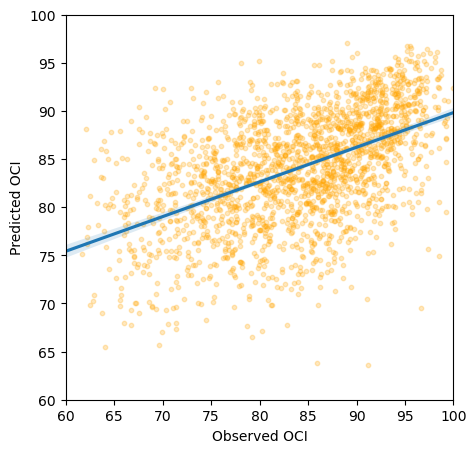

In [46]:
comparison_plot(y_test, y_pred)